# ATWR Evolution
This script uses data from the OpenPowerlifting project (https://www.openpowerlifting.org). <br>
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

In [2]:
data_types = {
              'Name': str,
              'Sex': str,
              'Event': str,
              'Equipment': str,
              'WeightClassKg': str,
              'BodyweightKg': float,
              'Tested': str,
              'Best3SquatKg': float,
              'Best3BenchKg': float,
              'Best3DeadliftKg': float,
              'Squat4Kg': float,
              'Bench4Kg': float,
              'Deadlift4Kg': float,
              'TotalKg': float,
              'Date': str,
              'Place': str
             }

opl = pd.read_csv('openpowerlifting.csv', dtype=data_types, usecols=list(data_types))

In [3]:
opl.rename(columns={'TotalKg':'Total'}, inplace=True)

In [4]:
opl['Tested'].fillna('No', inplace=True)

In [5]:
opl['Date'] = pd.to_datetime(opl['Date'])

In [6]:
opl['Squat'] = opl[['Best3SquatKg', 'Squat4Kg']].max(axis=1)
opl['Bench'] = opl[['Best3BenchKg', 'Bench4Kg']].max(axis=1)
opl['Deadlift'] = opl[['Best3DeadliftKg', 'Deadlift4Kg']].max(axis=1)

### Parameters
**Weight classes**: 44, 48, 52, 56, 60, 67.5, 75, 82.5, 90, 90+, 100, 110, 125, 140, 140+ <br>
**Event**: For squat, bench, and deadlift records, SBD means full-power. S, B, or D means all events.<br>
**Tested**: Use 'Yes' for tested and both 'Yes' and 'No' for untested.<br>
**Record Type**: Total, Squat, Bench, or Deadlift.

In [7]:
bw_range_low = 75
# use bw_range_high = 999 for SHW
bw_range_high = 82.5 
sex = 'M'
equipment = ['Raw', 'Wraps']
event = 'SBD'
tested = ['Yes', 'No']
record_type = 'Total'

In [8]:
if record_type == 'Total' and event != 'SBD':
    raise Exception(f'You can\'t combine record_type \'Total\' and event \'{event}\'.')

In [9]:
parameter_mask = (
                  (opl['BodyweightKg'] > bw_range_low)
                  & (opl['BodyweightKg'] <= bw_range_high)
                  & (opl['Sex'] == sex)
                  & (opl['Tested'].isin(tested))
                  & (opl['Event'].str.contains(event))
                  & (opl['Equipment'].isin(equipment))
                  & (~ opl['Place'].isin(['DQ', 'DD', 'NS']))
                 )

opl_filtered = opl[parameter_mask].sort_values(by=['Date'])

In [10]:
# running max of record
opl_filtered['Record'] = opl_filtered[record_type].expanding().max()

In [11]:
# keep only the earliest date for each record
record_evolution = opl_filtered.groupby('Record', as_index=False).agg({'Name': 'first','Date': 'min', 'Event': 'first'})

In [12]:
# keep only the largest value for results from the same day
record_evolution.drop_duplicates(subset='Date', keep='last', inplace=True, ignore_index=True)

In [13]:
record_evolution

,Record,Name,Date,Event
0,659.98,William Andrews #2,1964-09-05,SBD
1,671.32,Ronald Ray,1965-09-04,SBD
2,684.93,Bill Andrews,1966-09-03,SBD
3,707.50,Robert Memery,1967-02-26,SBD
4,726.20,Tom Overholtzer,1968-09-13,SBD
5,773.38,Tom Overholtzer,1970-09-01,SBD
6,791.52,Jack Barnes,1972-09-16,SBD
7,800.00,Ron Collins,1975-11-22,SBD
8,815.00,Ron Collins,1976-02-29,SBD
9,817.50,Ron Collins,1976-11-06,SBD


In [14]:
record_table = record_evolution[['Date', 'Name', 'Record']].copy()
record_table['Date'] = record_table['Date'].dt.strftime('%Y-%m-%d')
record_table['Name'] = record_evolution['Name'].str.replace(r' #\d', '')

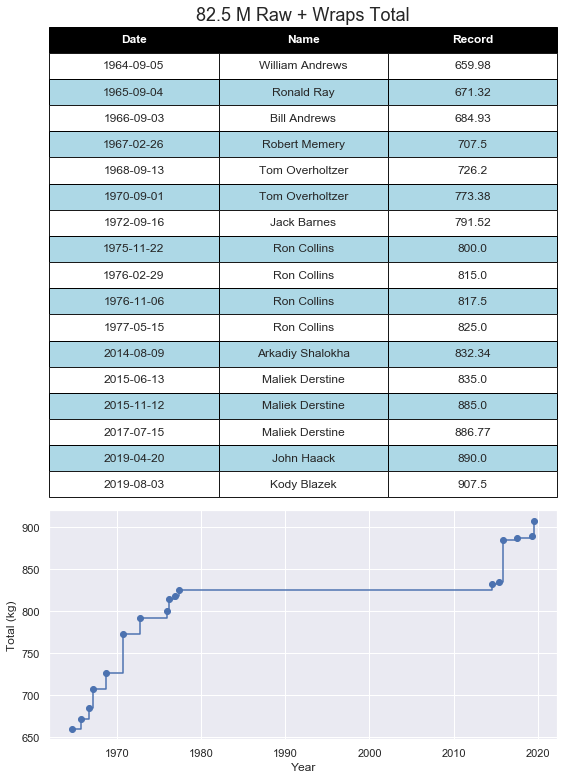

In [15]:
sns.set()

fig = plt.figure(figsize=(8, 11))
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
plot_1 = fig.add_subplot(spec[:2, 0])
plot_2 = fig.add_subplot(spec[2, 0])

# table
my_table = plot_1.table(cellText=record_table.values, 
                     colLabels=record_table.columns, 
                     cellLoc='center', 
                     bbox=[0, 0, 1, 1])

for (row, col), cell in my_table.get_celld().items():
    if (row == 0):
        cell.set_color('black')
        cell.set_text_props(color='white', fontweight='bold')

for (row, col), cell in my_table.get_celld().items():
    if (row % 2 == False and row != 0):
        cell.set_color('lightblue')
        cell.set_edgecolor('black')
        
plot_1.axis('off')

# step chart
plot_2.plot_date(record_evolution['Date'], record_evolution['Record'], ls='-', ds='steps-post')
plot_2.set_xlabel("Year")
plot_2.set_ylabel(f'{record_type} (kg)')

# title
if 'Yes' in tested and len(tested) == 1:
    is_tested = ' (Tested)'
else:
    is_tested = ''

if bw_range_high == 999:
    bw_range_high = 'SHW'
    
if event == 'SBD' and record_type != 'Total':
    single_lift = ' (Full Power)'
elif record_type != 'Total':
    single_lift = ' (All Events)'
else:
    single_lift = ''
    
chart_title = f'{bw_range_high} {sex} {" + ".join(str(x) for x in equipment)} {record_type}' + is_tested + single_lift

plot_1.set_title(chart_title, fontsize=18)

fig.tight_layout()

# plt.savefig(chart_title.replace('.', ','))

plt.show()